# Heteroskedasticity and Bias correction using linear transformations

This notebook works through an idea for correcting heteroskedasticity which uses rotation matrices to align samples. Previous iterations of seqpyplot (SPPLOT v0.3 and below) output a scatter plot that plots the expression values of control and treated samples and against their means. These plots revealed what appeared to be a bias where one sample tended towards overall higher expression than the other. Given the type of data being analyzed (Time series RNA seq data), it seemedunlikely that there would be such a bias inherent to the experiment.

In this notebook, I propose a method for correcting this bias using linear regression and linear transformations to rotate one of the two samples prior to differential experesssion inference. 

The steps to performing this transformation are as follows
1. For a given sample pair, compute the mean. 
2. For each sample and its repestive mean computed in step 1, perform linear regression to compute a regression coefficient (a line of best fit) through the sample/mean pair as well as a bias.
3. Zero out the sample bias by addition or subtraction across all points.
4. If the regression coeffieicients do not match, use the coefficients to compute the angle difference.
5. Compute a rotation matrix to rotate the data about the origin until they match, resulting in proper alignment between the control and treated samples.


References:
    Rotation Matrices: https://en.wikipedia.org/wiki/Rotation_matrix

In [6]:
import pandas as pd
import numpy as np
from random import randint as rand
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.metrics.pairwise import euclidean_distances

from scipy.linalg import svd

from seqpyplot.container.data_container import DataContainer
from seqpyplot.parsers.config_parser import config_parser
from pathlib import Path

from matplotlib import rcParams

rcParams['figure.figsize'] = (15, 15)

pd.options.mode.chained_assignment = None 

# Helper functions

In [7]:
def calc_theta(coef1, coef2):
    "Returns an angle in radians"
    return np.abs(
       np.arctan(np.abs(coef1 - coef2) / (1. + (coef1 * coef2)))
   )

In [8]:
def compute_rot_mat(rad, coef=.5):
    " Compute a rotation matrix using rad for a given regression coefficient "
    if coef < 1.0:
        rotation_matrix = np.array([[np.cos(rad), -np.sin(rad)],
                                    [np.sin(rad), np.cos(rad)]])
    else:
        rotation_matrix = np.array([[np.cos(rad), np.sin(rad)],
                                    [-np.sin(rad), np.cos(rad)]])  
    return rotation_matrix

# Simple example of line rotation
Example of rotating a line around the origin to match the slope of another line

In [9]:
slope1 = 1.1
slope2 = 2.0

line1 = np.array([slope1 * x for x in range(10)])
line2 = np.array([slope2 * x for x in range(10)])

xs = list(range(10))

#### Original Lines

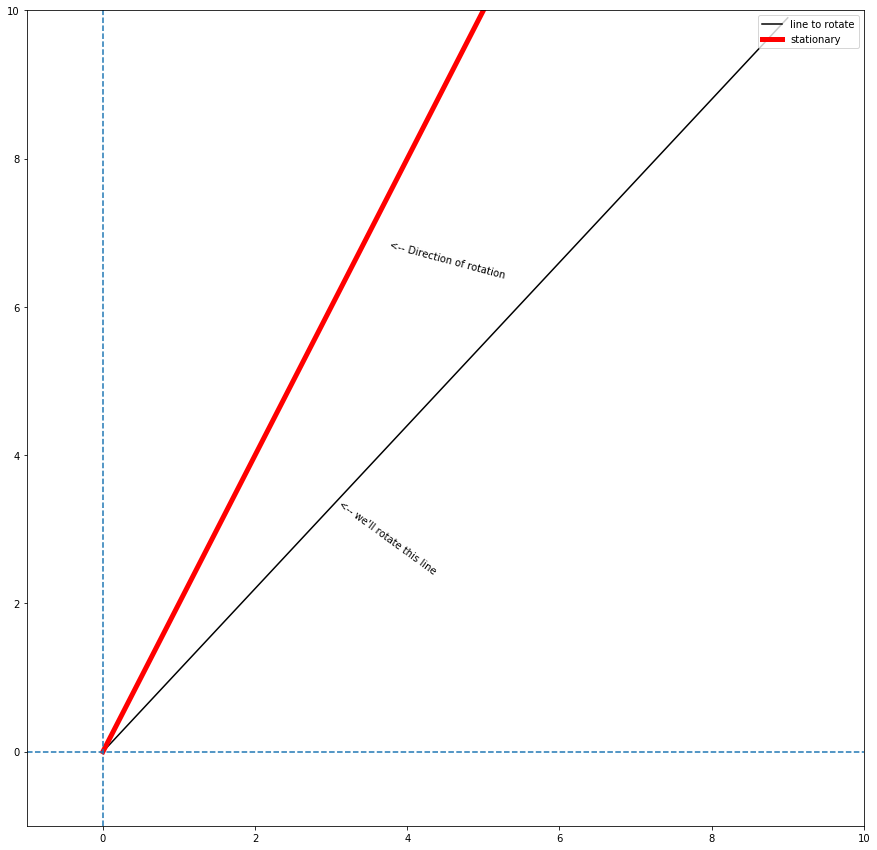

In [10]:
# Plot lines
plt.plot(xs, line1, color='black', label='line to rotate');
plt.plot(xs, line2, color='red', linewidth=5, label='stationary');
plt.axvline(0, linestyle='--')
plt.axhline(0, linestyle='--');

plt.annotate(s=('<-- we\'ll rotate this line'), xy=(xs[3]+0.08, line1[3]), rotation=-36)
plt.annotate(s=('<-- Direction of rotation'), xy=(xs[3] + 0.75, line1[3]+3.5), rotation=-15)

plt.ylim((-1, 10))
plt.xlim((-1, 10))
plt.legend(loc='upper right');

#### Rotated lines

In [11]:
# Compute angle
angle_diff = calc_theta(slope1, slope2)
angle_diff

0.27416745111965873

In [12]:
# Compute rotation matrix
rot_matrix = compute_rot_mat(angle_diff)
rot_matrix

array([[ 0.96265094, -0.27074558],
       [ 0.27074558,  0.96265094]])

In [13]:
# rotate line 1 (black line)
new_line1 = list()
for x, y in zip(xs, line1):
    # need shape [[#], [#]]
    old_point = np.array([[x], [y]])
    new_point = np.dot(rot_matrix, old_point)
    new_line1.append(new_point)
new_line1 = np.squeeze(np.asarray(new_line1))

In [14]:
xs[6], line1[6]

(6, 6.6000000000000005)

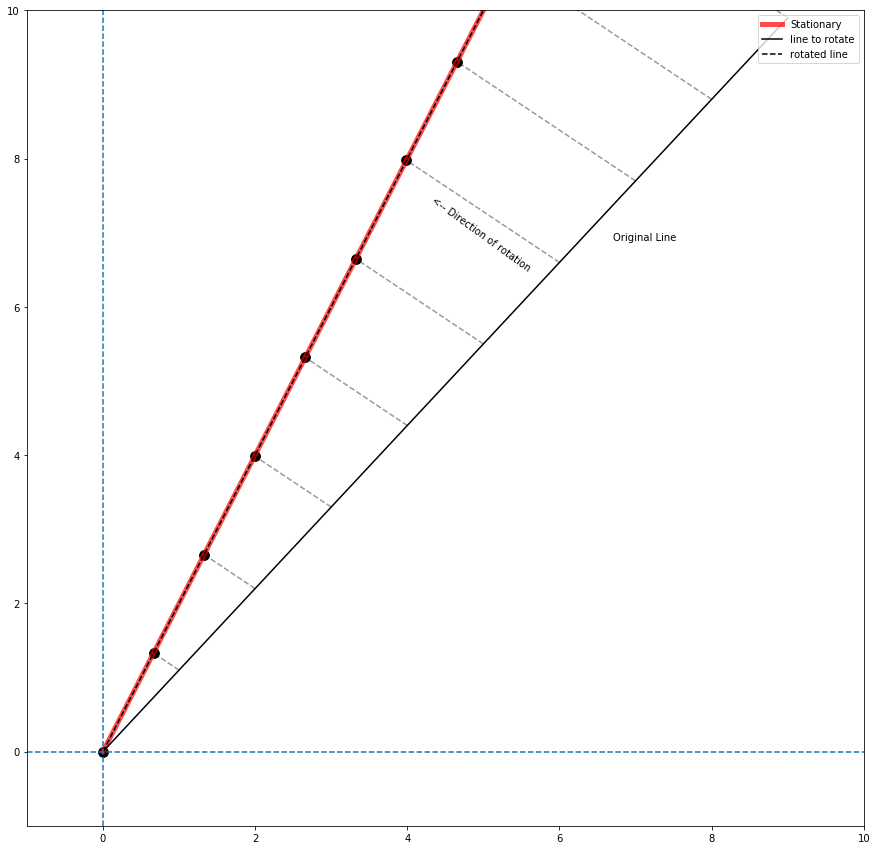

In [15]:
plt.plot(xs, line2, color='red', linewidth=5, alpha=0.7, label='Stationary');

plt.plot(xs, line1, color='black', label='line to rotate')
plt.scatter(new_line1[:, 0], new_line1[:, 1], color='black', s=95)
plt.plot(new_line1[:, 0], new_line1[:, 1], color='black', linestyle='--', label='rotated line')

plt.annotate(s=('Original Line'), xy=(xs[6] + 0.7, line1[6]+0.3))
plt.annotate(s=('<-- Direction of rotation'), xy=(xs[6] - 1.7, line1[6]+0.8), rotation=-36)

plt.axvline(0, linestyle='--')
plt.axhline(0, linestyle='--')

for (x1, y1), (x2, y2) in zip(zip(xs, line1), new_line1):
    plt.plot([x1, x2], [y1, y2], linestyle='--', color='black', alpha=0.4)

plt.ylim((-1, 10))
plt.xlim((-1, 10));
plt.legend(loc='upper right');

# Examle using raw expression Data
(No TMM normalization)

In [16]:
config = '../examples/example_config.ini'
config_obj = config_parser(config)

In [17]:
# load the data container_obj
container_obj = DataContainer(config_obj)
data, ercc_data = container_obj.parse_input()

In [18]:
cols = data.columns
cols

Index(['D1_Cont', 'D2_Cont', 'D3_Cont', 'D1_Treat', 'D2_Treat', 'D3_Treat'], dtype='object')

In [19]:
df = data[['D1_Cont', 'D1_Treat']]
df.loc[:, 'mean'] = df.mean(axis=1)

In [20]:
df.head()

,D1_Cont,D1_Treat,mean
gene,,,
0610005C13Rik,16,30,23.0
0610007P14Rik,333,364,348.5
0610009B22Rik,150,220,185.0
0610009L18Rik,20,25,22.5
0610009O20Rik,680,805,742.5


In [21]:
d1 = df[['D1_Cont', 'mean']]
d2 = df[['D1_Treat', 'mean']]

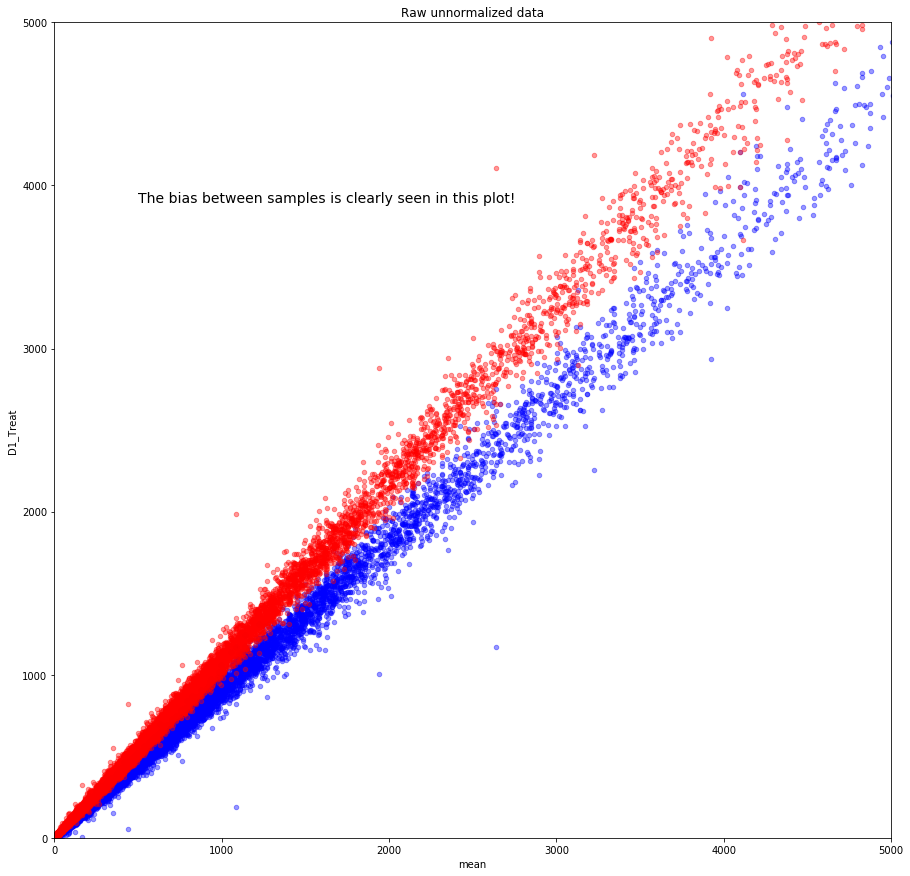

In [22]:
fig, ax = plt.subplots()
d1.plot('mean', 'D1_Cont', kind='scatter', xlim=(0, 5000), ylim=(0, 5000), ax=ax, color='blue', alpha=0.4)
d2.plot('mean', 'D1_Treat', kind='scatter', xlim=(0, 5000), ylim=(0, 5000), ax=ax, color='red', alpha=0.4);
plt.annotate('The bias between samples is clearly seen in this plot!', (500, 3900), fontsize=14)
ax.set_title("Raw unnormalized data");

No handles with labels found to put in legend.


[[1.10159719]] [-1.68423257]
[[0.9083203]] [5.21303275]


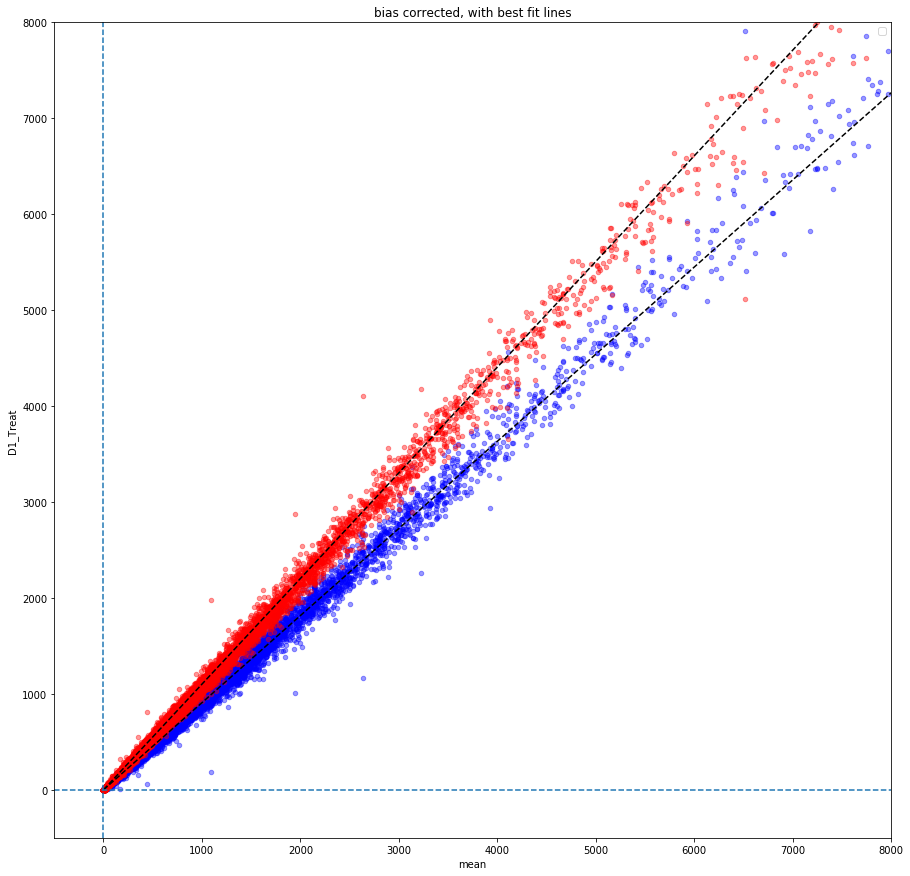

In [23]:
# Quick reset for this cell
d1 = df[['D1_Cont', 'mean']]
d2 = df[['D1_Treat', 'mean']]

# define regression objects
regCont = LinearRegression(fit_intercept=True)
regTreat = LinearRegression(fit_intercept=True)

# fit regression
regCont.fit(d1['D1_Cont'].values.reshape(-1, 1), d1['mean'].values.reshape(-1, 1))
regTreat.fit(d2['D1_Treat'].values.reshape(-1, 1), d1['mean'].values.reshape(-1, 1))

print(regCont.coef_, regCont.intercept_)
print(regTreat.coef_, regTreat.intercept_)

# Correct bias
d1['D1_Cont'] = d1['D1_Cont'] - regCont.intercept_
d2['D1_Treat'] = d2['D1_Treat'] - regTreat.intercept_

# Plot regression lines
fig, ax = plt.subplots()
d1.plot('mean', 'D1_Cont', kind='scatter', ax=ax, color='blue', alpha=0.4)
d2.plot('mean', 'D1_Treat', kind='scatter', xlim=(0, 8000), ylim=(0, 8000), ax=ax, color='red',  alpha=0.4)
plt.plot([0, 8000], [0.0, regCont.coef_ * 8000], linestyle='--', color='black')
plt.plot([0, 8000], [0.0, regTreat.coef_ * 8000], linestyle='--', color='black');
ax.set_title("bias corrected, with best fit lines");

plt.ylim((-500, 8000))
plt.xlim((-500, 8000));
plt.axvline(0, linestyle='--')
plt.axhline(0, linestyle='--')
plt.legend();

#### Compute rotation linear transformation

No handles with labels found to put in legend.


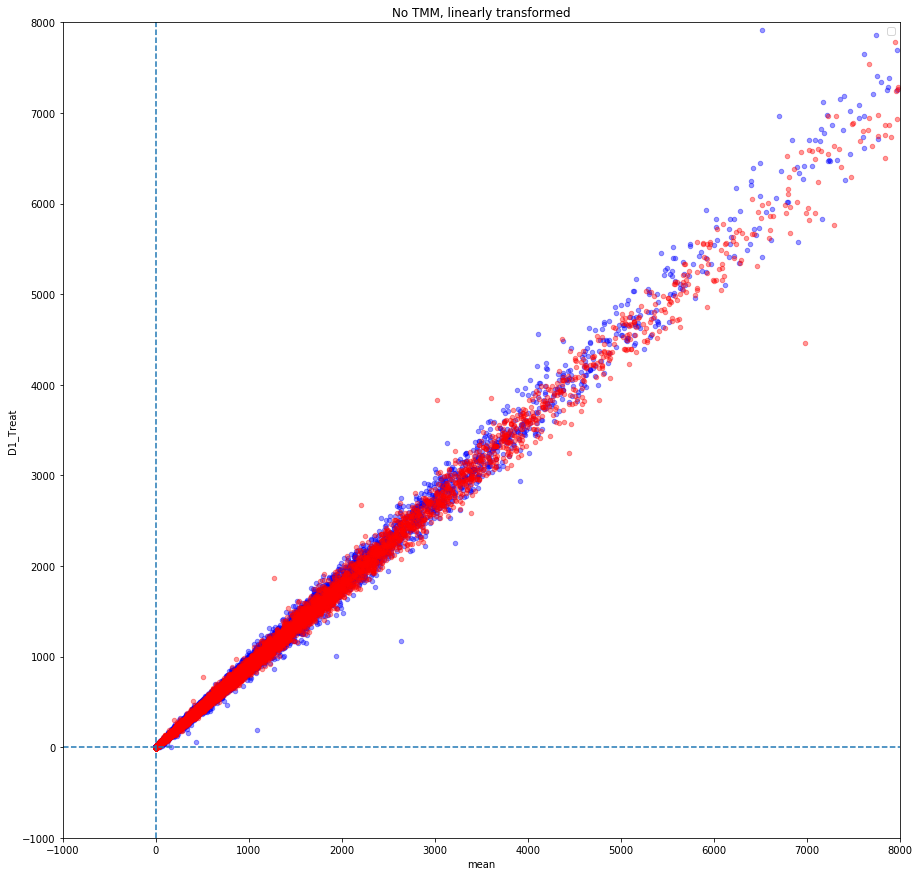

In [24]:
correction_theta = calc_theta(np.squeeze(regCont.coef_), np.squeeze(regTreat.coef_))
correction_theta  # in radians

rotation_matrix = compute_rot_mat(correction_theta)
rotation_matrix

new_treat = np.array([np.dot(rotation_matrix, d2.values[i, :]) for i in range(len(d2.values))])
new_treat

d2_cor = d2.copy()
d2_cor.loc[:, 'D1_Treat'] = new_treat[:, 0]
d2_cor.loc[:, 'mean'] = new_treat[:, 1]

fig, ax = plt.subplots()
d1.plot('mean', 'D1_Cont', kind='scatter', xlim=(0, 20000), ylim=(0, 20000), ax=ax, color='blue', alpha=0.4)
d2_cor.plot('mean', 'D1_Treat', kind='scatter', xlim=(0, 5000), ylim=(0, 5000), ax=ax, color='red', alpha=0.4);
ax.set_title("No TMM, linearly transformed")

plt.ylim((-1000, 8000))
plt.xlim((-1000, 8000));
plt.axvline(0, linestyle='--')
plt.axhline(0, linestyle='--')
plt.legend();

Successs! We have eliminated the sample divergence!

# Use TMM before linear transformation

There could still be advantage in normalizing the samples prior to performing the linear transformation.

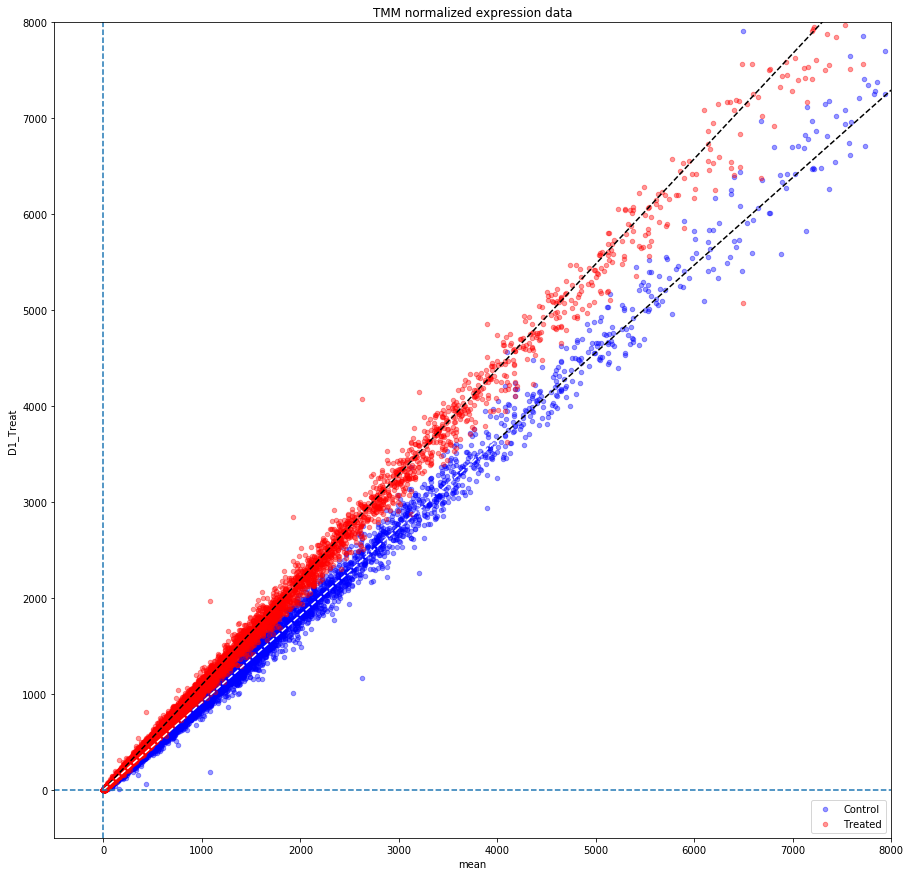

In [109]:
# load the data container_obj
config = '../examples/example_config.ini'
config_obj = config_parser(config)

container_obj = DataContainer(config_obj)
data, ercc_data = container_obj.parse_input()

data = container_obj.normalize_file_pairs(data) # Single df of normalized data

normed_df = data[['D1_Cont', 'D1_Treat']].copy()
normed_df.loc[:, 'mean'] = normed_df.mean(axis=1)
 
regCont = LinearRegression(fit_intercept=True)
regTreat = LinearRegression(fit_intercept=True)

regCont.fit(normed_df['D1_Cont'].values.reshape(-1, 1), normed_df['mean'].values.reshape(-1, 1))
regTreat.fit(normed_df['D1_Treat'].values.reshape(-1, 1), normed_df['mean'].values.reshape(-1, 1))

normed_df['D1_Cont'] = normed_df['D1_Cont'] - regCont.intercept_
normed_df['D1_Treat'] = normed_df['D1_Treat'] - regTreat.intercept_

fig, ax = plt.subplots()
normed_df.plot('mean', 'D1_Cont', kind='scatter',
               xlim=(0, 5000), ylim=(0, 8000), ax=ax, color='blue', alpha=0.4, label='Control')
normed_df.plot('mean', 'D1_Treat', kind='scatter',
               xlim=(0, 5000), ylim=(0, 8000), ax=ax, color='red', alpha=0.4, label='Treated')

# plot regression lines, with color switch!
plt.plot([0, 8000], [0.0, regCont.coef_ * 8000], linestyle='--', color='black')
plt.plot([0, 4000], [0.0, regTreat.coef_ * 4000], linestyle='--', color='white');
plt.plot([4000, 8000], [regTreat.coef_[0] * 4000.0, regTreat.coef_[0] * 8000], linestyle='--', color='black');

ax.set_title("TMM normalized expression data");

plt.ylim((-500, 8000))
plt.xlim((-500, 8000));
plt.axvline(0, linestyle='--')
plt.axhline(0, linestyle='--')
plt.legend();

#### Compute linear transformation

No handles with labels found to put in legend.


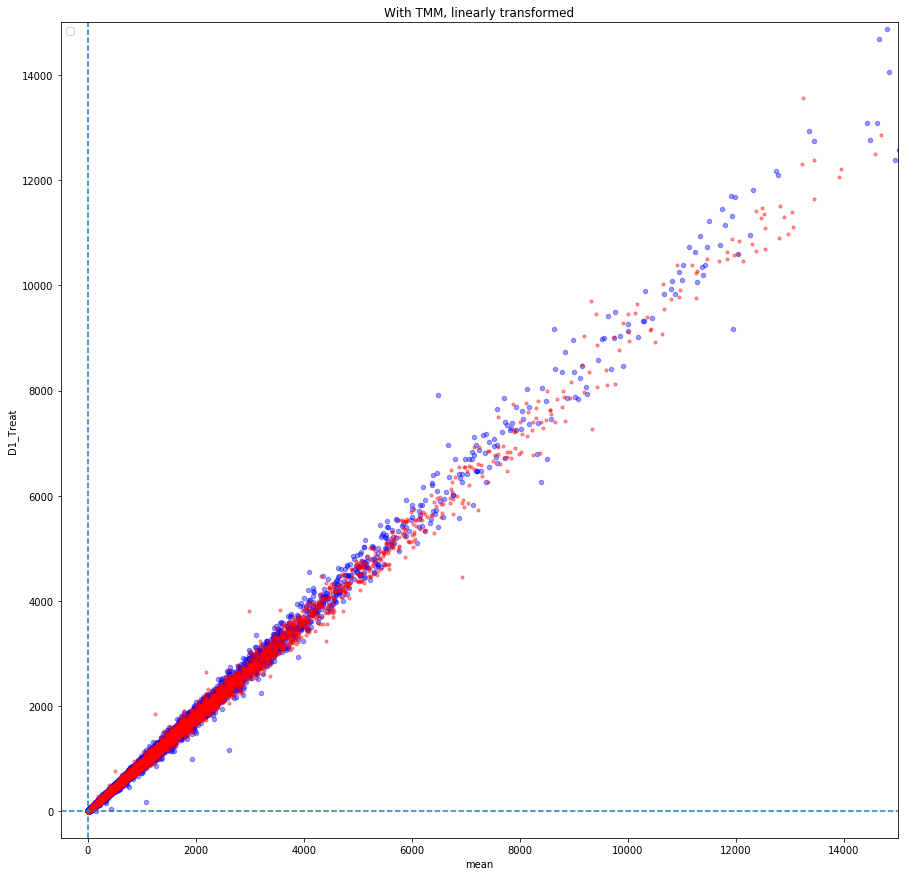

In [110]:
correction_theta = calc_theta(np.squeeze(regCont.coef_), np.squeeze(regTreat.coef_))
correction_theta  # in radians

rotation_matrix = compute_rot_mat(correction_theta, regTreat.coef_)
rotation_matrix

new_treat = np.array([np.dot(rotation_matrix, normed_df[['D1_Treat', 'mean']].values[i, :]) for i in range(len(normed_df))])

corr_df = normed_df.copy()
corr_df.loc[:, 'D1_Treat'] = new_treat[:, 0]
corr_df.loc[:, 'mean'] = new_treat[:, 1]

fig, ax = plt.subplots()
normed_df.plot('mean', 'D1_Cont', kind='scatter', xlim=(0, 20000), ylim=(0, 20000), ax=ax, color='blue', alpha=0.4)
corr_df.plot('mean', 'D1_Treat', kind='scatter', xlim=(0, 5000), ylim=(0, 5000), ax=ax, color='red', alpha=0.4, s=10);
ax.set_title("With TMM, linearly transformed");

plt.ylim((-500, 15000))
plt.xlim((-500, 15000));
plt.axvline(0, linestyle='--')
plt.axhline(0, linestyle='--')
plt.legend();

# Outlier detection

With the transformed data, we need a new metric for detecting outliers. While previously we described points with a single unique value and a common shared value, this transformed data is now represented with four unique values (two points for each sample).

Fortunately, we can still measure the distance between these points using euclidean distance. We can also create a new regression line using all of this new data from which we can establish a logfold threshold - thus providing a baseline for euclidean distance measurements. We can compute this threshold distance using the following algorithm:

1. Compute the regression coefficient for the new data (concat the data frames for each sample).
2. Compute the upper and lower thersholds given the user selected logfold threshold.
3. Compute the euclidean distance between all sample point pairs.

In [111]:
normed_df.drop('D1_Treat', axis=1, inplace=True)
normed_df.rename(columns={'mean': 'cont_mean'}, inplace=True)
normed_df.head()

,D1_Cont,cont_mean
gene,,
0610005C13Rik,17.669851,22.871915
0610007P14Rik,334.669851,346.945906
0610009B22Rik,151.669851,184.060712
0610009L18Rik,21.669851,22.393263
0610009O20Rik,681.669851,739.063062


In [112]:
corr_df.drop('D1_Cont', axis=1, inplace=True)
corr_df.rename(columns={'mean': 'treat_mean'}, inplace=True)
corr_df.head()

,D1_Treat,treat_mean
gene,,
0610005C13Rik,22.324301,25.030185
0610007P14Rik,322.277828,378.174375
0610009B22Rik,195.086080,202.854013
0610009L18Rik,17.431990,24.097833
0610009O20Rik,721.613233,808.826136


In [113]:
def euclidean_distance(p, q):
    return np.sqrt(
        np.sum(
    ((p[0] - q[0]) ** 2) + ((p[1] - q[1]) ** 2)
    ))

In [114]:
distances = list()
for i in normed_df.index:
    p = normed_df.loc[i, :].values
    q = corr_df.loc[i, :].values
    distances.append(euclidean_distance(p, q))

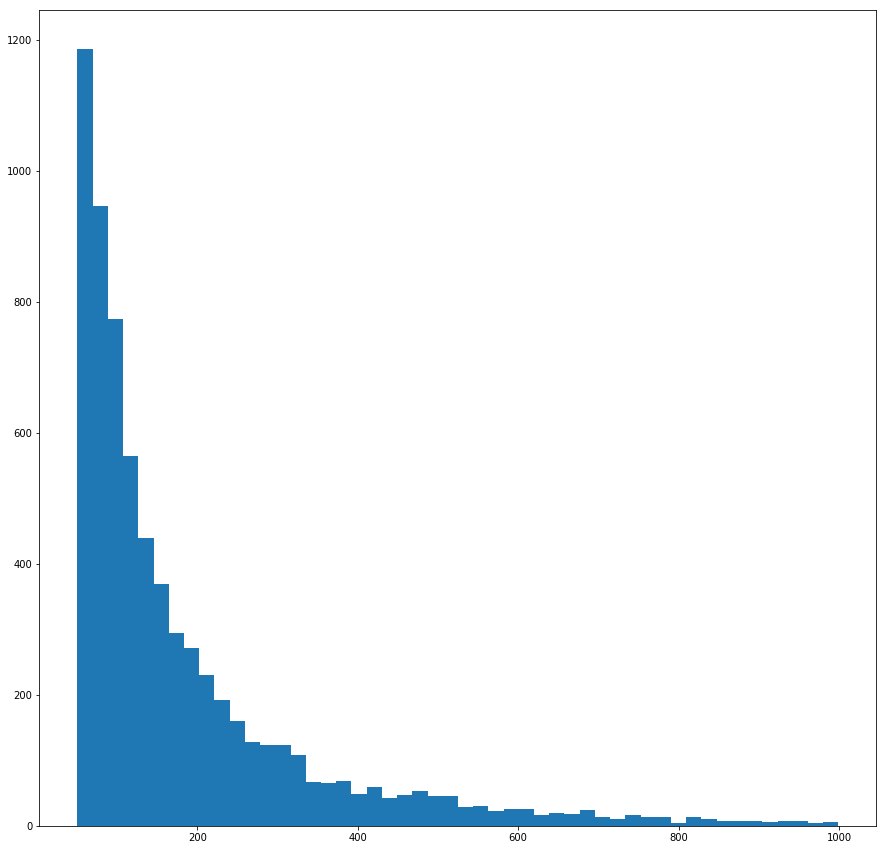

In [115]:
filt_points = sorted(list(filter(lambda x: (x < 1000) & (x > 50), distances)))
plt.hist(filt_points[50:], bins=50);

#### Plot a log2Fold range around the regression line

In [116]:
def calc_bounds(series_mean, var=0.5):
    """
    Use some linear algebra to calculate log2fold range around a given value based on user logfold parameter
    """
    return np.array([i - ((2.0 * i) / ((2.0 ** var) + 1)) for i in series_mean])

In [117]:
main = np.array([0, 5, 10])

In [118]:
spread = calc_bounds(main)

In [119]:
spread

array([0.        , 0.85786438, 1.71572875])

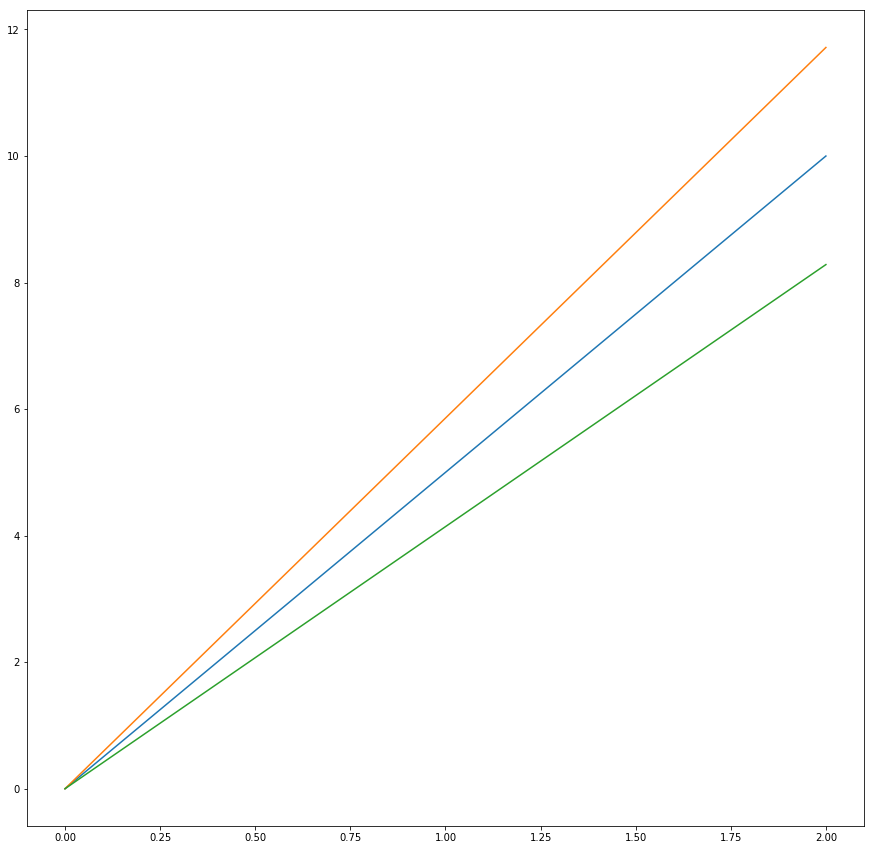

In [120]:
plt.plot(main)
plt.plot(main + spread)
plt.plot(main - spread);

In [95]:
abs(series_mean)

array([[0.00000000e+00],
       [1.09629273e+00],
       [2.19258545e+00],
       ...,
       [8.76705293e+03],
       [8.76814922e+03],
       [8.76924552e+03]])

No handles with labels found to put in legend.


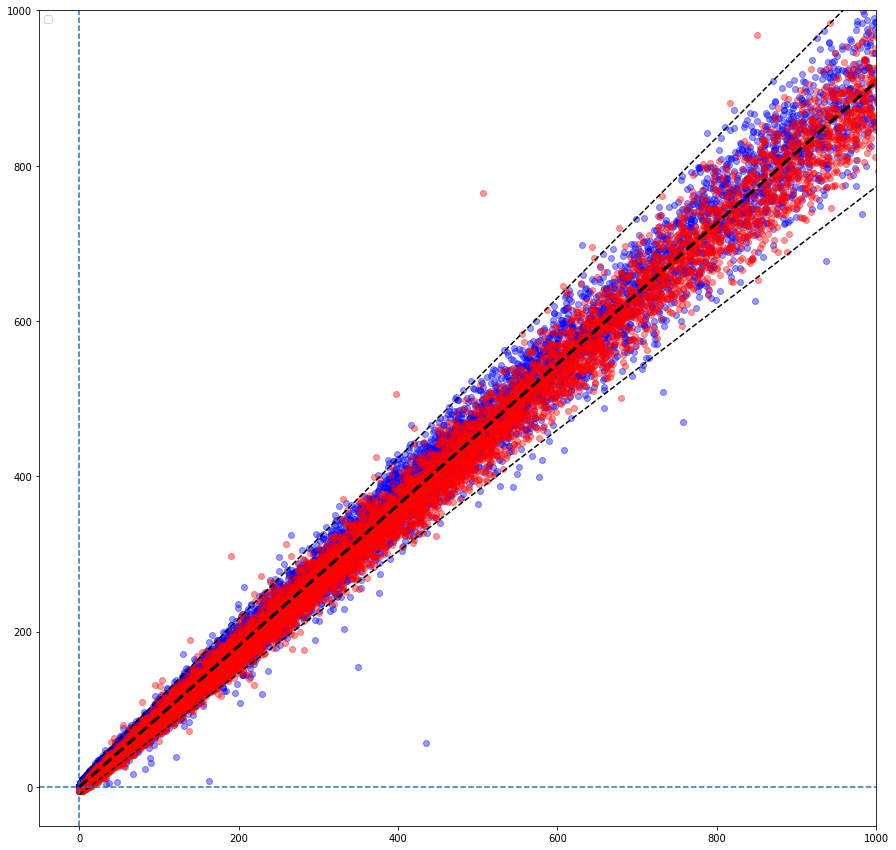

In [202]:
tot_data = pd.concat([normed_df.rename(columns={'D1_Cont': 'expr', 'cont_mean': 'mean'}, inplace=False),
                      corr_df.rename(columns={'D1_Treat': 'expr', 'treat_mean': 'mean'}, inplace=False)], axis=0)

tot_reg = LinearRegression(fit_intercept=True)
tot_reg.fit(tot_data['mean'].values.reshape(-1, 1), tot_data['expr'].values.reshape(-1, 1))

series_mean = np.array([x * tot_reg.coef_[0] for x in range(8000)])

spread = calc_bounds(series_mean, var=0.4)
plt.scatter(normed_df.values[:, 1], normed_df.values[:, 0], color='blue', alpha=0.4)
plt.scatter(corr_df.values[:, 1],   corr_df.values[:, 0],   color='red',  alpha=0.4)

bias = 10

plt.plot(series_mean + spread + bias, color='black', linestyle='--')
plt.plot(series_mean - spread - bias, color='black', linestyle='--')

plt.ylim((-50, 1000))
plt.xlim((-50, 1000));
plt.axvline(0, linestyle='--')
plt.axhline(0, linestyle='--')

plt.plot([0, 20000], [0, tot_reg.coef_[0][0] * 20000], color='black', linewidth=3, linestyle='--')
plt.legend();

In [203]:
joined_data.head()

,D1_Cont,cont_mean,D1_Treat,treat_mean,distance
gene,,,,,
0610005C13Rik,17.669851,22.871915,22.324301,25.030185,5.130500
0610007P14Rik,334.669851,346.945906,322.277828,378.174375,33.597314
0610009B22Rik,151.669851,184.060712,195.086080,202.854013,47.309165
0610009L18Rik,21.669851,22.393263,17.431990,24.097833,4.567825
0610009O20Rik,681.669851,739.063062,721.613233,808.826136,80.388808


#### Compute euclidean distance betwen sample points

In [217]:
joined_data = pd.concat([normed_df, corr_df], axis=1)

results = list()
for row in joined_data.iterrows():
    row = row[1]
    p = [row['cont_mean'], row['D1_Cont']]
    q = [row['treat_mean'], row['D1_Treat']]
    results.append(euclidean_distance(p, q))

joined_data.loc[:, 'distance'] = results

In [218]:
joined_data.head()

,D1_Cont,cont_mean,D1_Treat,treat_mean,distance
gene,,,,,
0610005C13Rik,17.669851,22.871915,22.324301,25.030185,5.130500
0610007P14Rik,334.669851,346.945906,322.277828,378.174375,33.597314
0610009B22Rik,151.669851,184.060712,195.086080,202.854013,47.309165
0610009L18Rik,21.669851,22.393263,17.431990,24.097833,4.567825
0610009O20Rik,681.669851,739.063062,721.613233,808.826136,80.388808


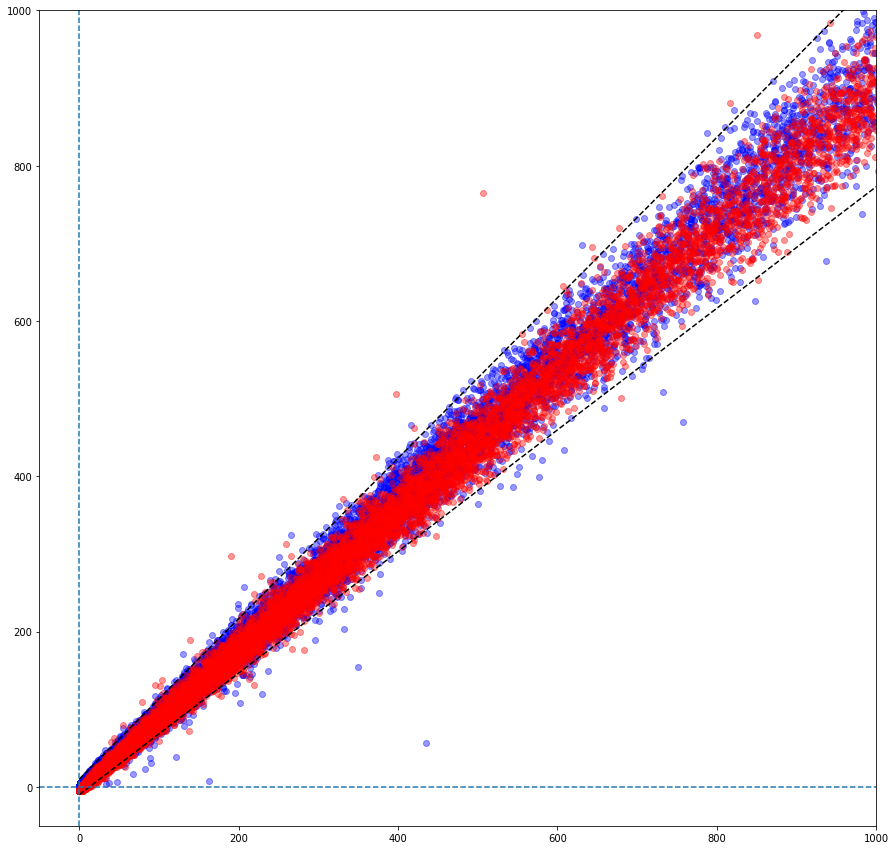

In [219]:
up = 1000
low = 500

# jd = joined_data[(joined_data['distance'] > up) & (joined_data['distance'] > low)].copy()
# jd = joined_data.loc[joined_data.index[4: 5]]
jd = joined_data
plt.scatter(jd.values[:, 1], jd.values[:, 0], color='blue', alpha=0.4)
plt.scatter(jd.values[:, 3], jd.values[:, 2], color='red',  alpha=0.4)

plt.plot(series_mean + spread + bias, color='black', linestyle='--')
plt.plot(series_mean - spread - bias, color='black', linestyle='--')

plt.ylim((-50, 1000))
plt.xlim((-50, 1000));
plt.axvline(0, linestyle='--')
plt.axhline(0, linestyle='--');

#### Computer center point for each sample pair

In [220]:
jd = joined_data.loc[joined_data.index[4: 5]]
jd

,D1_Cont,cont_mean,D1_Treat,treat_mean,distance
gene,,,,,
0610009O20Rik,681.669851,739.063062,721.613233,808.826136,80.388808


In [221]:
x1, x2 = jd.values[0][1], jd.values[0][3]
y1, y2 = jd.values[0][0], jd.values[0][2]

In [222]:
avex = (x1 + x2) / 2.
avey = (y1 + y2) / 2.

In [297]:
def center_point(p, q):
    avex = (p[0] + q[0]) / 2.
    avey = (p[1] + q[1]) / 2.
    return avex, avey

In [298]:
avex, avey = center_point([x1, y1], [x2, y2])

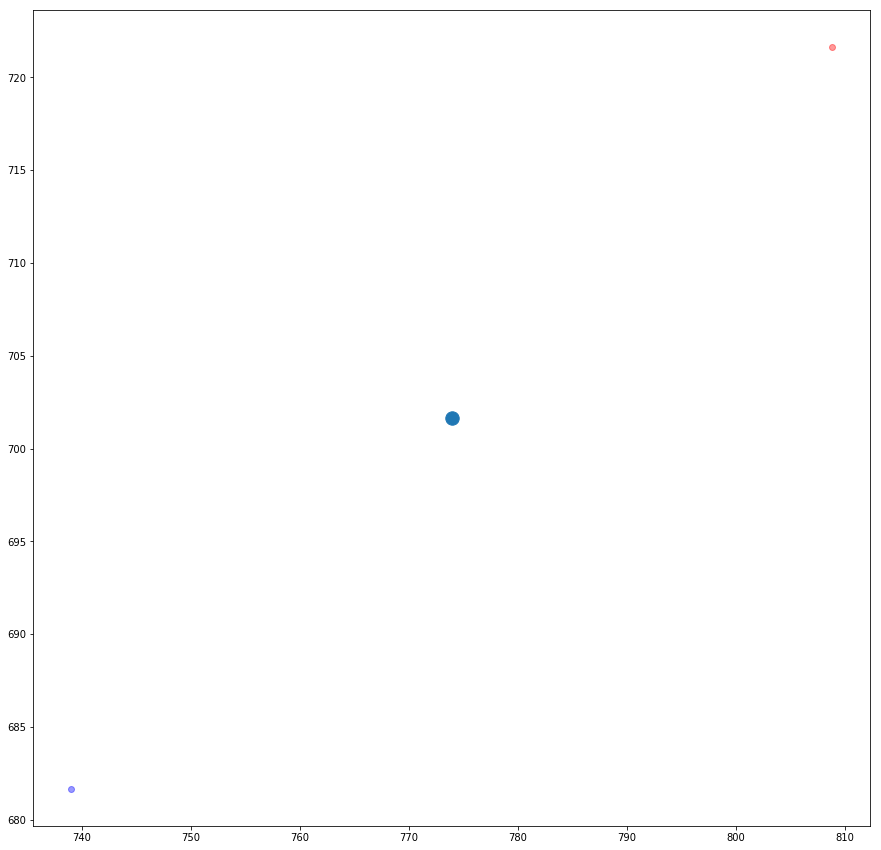

In [299]:
plt.scatter(jd.values[:, 1], jd.values[:, 0], color='blue', alpha=0.4)
plt.scatter(jd.values[:, 3], jd.values[:, 2], color='red',  alpha=0.4)
plt.scatter(avex, avey, s=180);

In [305]:
len(centers)

24421

In [306]:
len(joined_data)

24421

In [308]:
centers = list()
for row in joined_data.iterrows():
    row = row[1]
    p = [row['cont_mean'], row['D1_Cont']]
    q = [row['treat_mean'], row['D1_Treat']]
    centers.append(center_point(p, q))

In [310]:
joined_data.loc[:, 'centers'] = list(centers)

ValueError: Must have equal len keys and value when setting with an ndarray

In [314]:
x_vals = np.array([list(x) for x in joined_data['centers'].values])[:, 0]

In [315]:
center_dist = calc_bounds(x_vals, var=0.4)

In [319]:
joined_data.loc[:, 'min_dist'] = center_dist*2

In [321]:
joined_data.head()

,D1_Cont,cont_mean,D1_Treat,treat_mean,distance,centers,min_dist
gene,,,,,,,
0610005C13Rik,17.669851,22.871915,22.324301,25.030185,5.130500,"(23.95105001977266, 19.997075935497566)",6.598425
0610007P14Rik,334.669851,346.945906,322.277828,378.174375,33.597314,"(362.56014032171174, 328.473839369501)",99.883973
0610009B22Rik,151.669851,184.060712,195.086080,202.854013,47.309165,"(193.4573629148389, 173.37796545594148)",53.296786
0610009L18Rik,21.669851,22.393263,17.431990,24.097833,4.567825,"(23.245547833220016, 19.55092066998175)",6.404062
0610009O20Rik,681.669851,739.063062,721.613233,808.826136,80.388808,"(773.9445989738537, 701.6415421925549)",213.218865


In [327]:
test_filtered = joined_data[joined_data['min_dist'] < joined_data['distance']]
test_filtered.head()

,D1_Cont,cont_mean,D1_Treat,treat_mean,distance,centers,min_dist
gene,,,,,,,
0610010B08Rik,1.669851,1.487192,-2.365888,1.275094,4.041308,"(1.3811429651573586, -0.3480184514336204)",0.380500
0610011F06Rik,222.669851,204.193067,162.630167,220.075614,62.104903,"(212.13434032688468, 192.6500087947257)",58.442224
0610031O16Rik,1.669851,0.000000,-5.190958,-0.479235,6.877526,"(-0.2396176178740798, -1.7605534800928409)",-0.066014
0610039H22Rik,12.669851,12.440227,7.487086,13.184346,5.235911,"(12.81228676214696, 10.078468554836451)",3.529737
0610039K10Rik,1.669851,0.991461,-3.307578,0.690318,4.986530,"(0.8408894374802125, -0.8188634609866938)",0.231662


# Choosing thresholds for outlier cutoffs

Before performing rotation correction, its a good idea to eliminate some of the worst outlier offenders before performing linear regression. To do this, we can calculate summary statistics on the sample pair, and 

In [113]:
config = '../examples/example_config.ini'
config_obj = config_parser(config)

# load the data container_obj
container_obj = DataContainer(config_obj)
data, ercc_data = container_obj.parse_input()

data = container_obj.normalize_file_pairs(data) # Single df of normalized data

df = data[['D1_Cont', 'D1_Treat']].copy()
df.loc[:, 'mean'] = df.mean(axis=1)
df.loc[:, 'var'] = (df['D1_Cont'] - df['mean']).abs()
df.loc[:, 'diff'] = (df['D1_Cont'] - df['D1_Treat']).abs()


In [114]:
described = df[df['diff'] > 0.0].describe(percentiles=[x /10. for x in range(10)])

In [115]:
deef = described.copy()
deef.drop(['count', 'mean', 'std', 'min', 'max'], axis=0, inplace=True)
columns = deef.columns
idx = deef.index.tolist()

In [116]:
deef

,D1_Cont,D1_Treat,mean,var,diff
0%,0.0,0.000000,0.495731,0.000470,0.000940
10%,1.0,1.982922,1.495731,0.500000,1.000000
20%,6.0,7.931688,6.474383,1.051704,2.103407
30%,19.0,24.786526,21.414610,2.512808,5.025617
40%,60.0,74.359577,68.149902,5.548374,11.096748
50%,145.0,174.497140,160.714414,11.615746,23.231492
60%,274.0,328.173598,301.625225,21.415550,42.831100
70%,454.0,537.371874,496.638973,38.646102,77.292204
80%,763.0,905.203913,835.289814,67.705364,135.410728
90%,1410.0,1671.603284,1545.322989,136.783154,273.566309


Using the 75th percentile is typical practice. Based on thse summary stats, it doens't seem unreasonable to take up to the 90th percentile, however a conservative estimate is likely to improve results.

/Users/pgradie/miniconda-3.9.1/envs/py3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


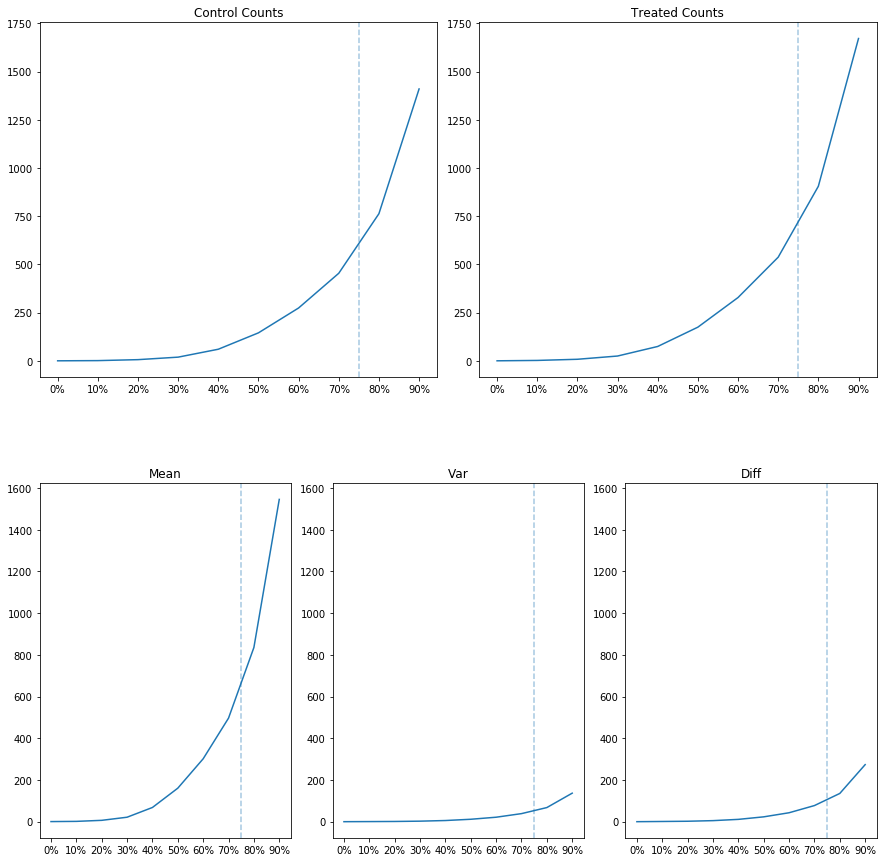

In [117]:
fig = plt.figure()
grid = plt.GridSpec(2, 6, wspace=0.4, hspace=0.3)

ax1 = plt.subplot(grid[0, 0:3])
ax1.plot(idx, deef['D1_Cont'])
plt.title('Control Counts')
plt.axvline(7.5, linestyle='--', alpha=0.4)

ax2 = plt.subplot(grid[0, 3:6], sharey=ax1)
ax2.plot(idx, deef['D1_Treat'])
plt.title('Treated Counts')
plt.axvline(7.5, linestyle='--', alpha=0.4)

ax3 = plt.subplot(grid[1, 0:2])
ax3.plot(idx, deef['mean'])
plt.title('Mean')
plt.axvline(7.5, linestyle='--', alpha=0.4)

ax4 = plt.subplot(grid[1, 2:4], sharey=ax3)
ax4.plot(idx, deef['var'])
plt.title('Var')
plt.axvline(7.5, linestyle='--', alpha=0.4)

ax5 = plt.subplot(grid[1, 4:6], sharey=ax3)
ax5.plot(idx, deef['diff'])
plt.title('Diff')
plt.axvline(7.5, linestyle='--', alpha=0.4)

plt.tight_layout();

In [118]:
perc_filtered = df #[df['diff'] < deef.describe().loc['75%']['diff']]

In [119]:
def rotate(rotation_matrix, points):
    return np.array([np.dot(rotation_matrix, points.values[i, :]) for i in range(len(points.values))])

def calc_theta(coef1, coef2):
    "returns radians"
    return np.abs(
       np.arctan(np.abs(coef1 - coef2) / (1. + (coef1 * coef2)))
   )

def compute_rot_mat(rad, coef):
    if coef < 1.0:
        rotation_matrix = np.array([[np.cos(rad), -np.sin(rad)],
                                    [np.sin(rad), np.cos(rad)]])
    else:
        rotation_matrix = np.array([[np.cos(rad), np.sin(rad)],
                                    [-np.sin(rad), np.cos(rad)]])  
    return rotation_matrix

[[1.09273472]]
[[0.90726528]]
theta 0.09286729328763023
[[ 0.99569093 -0.09273386]
 [ 0.09273386  0.99569093]]


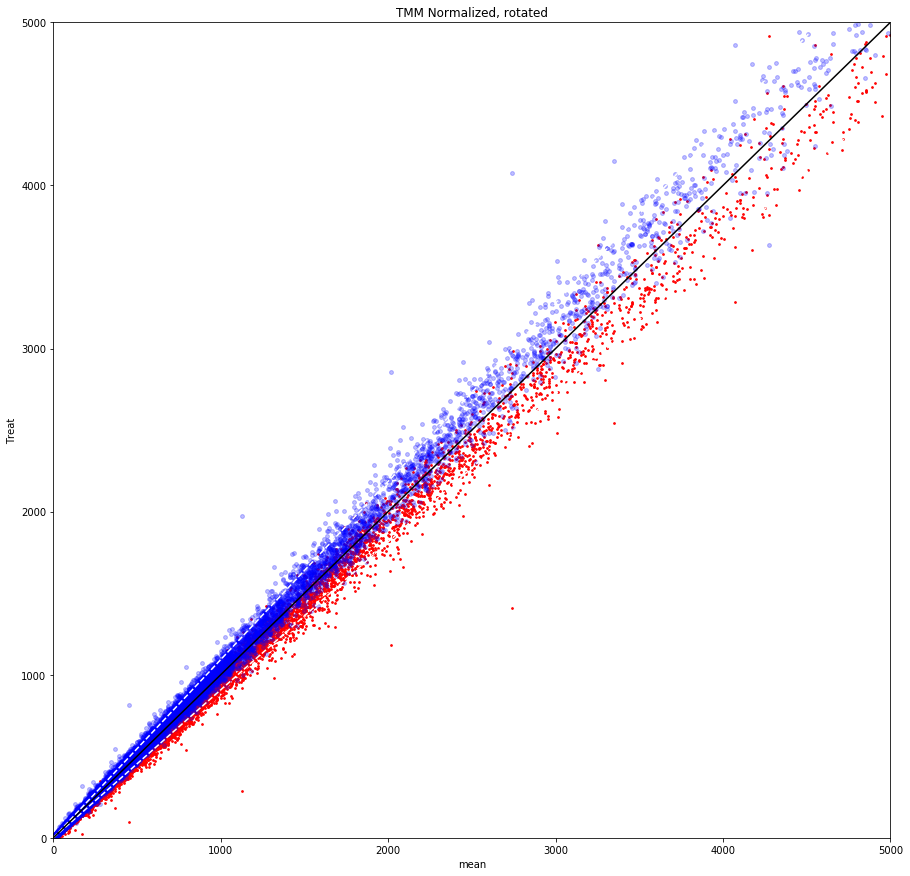

In [120]:
# Compute regression
regCont = LinearRegression(fit_intercept=True)
regTreat = LinearRegression(fit_intercept=True)

# Fit regression line
regCont.fit( perc_filtered['mean'].values.reshape(-1, 1), perc_filtered['D1_Cont'].values.reshape(-1, 1))
regTreat.fit(perc_filtered['mean'].values.reshape(-1, 1), perc_filtered['D1_Treat'].values.reshape(-1, 1))
print(regTreat.coef_)
print(regCont.coef_)

# Correct Bias
# df['D1_Cont'] = df['D1_Cont'] - regCont.intercept_
# df['D1_Treat'] = df['D1_Treat'] - regTreat.intercept_

# Compute theta in radians
theta = calc_theta(regTreat.coef_[0][0], regCont.coef_[0][0])
print('theta', theta)
# theta=0.1

# Compute rotation Matrix
rotation_matrix_cont = compute_rot_mat(theta, regCont.coef_[0][0])
print(rotation_matrix_cont)

# rotate data
new_cont = rotate(rotation_matrix_cont, df[['mean', 'D1_Cont']])

# reassign data
new_data = pd.DataFrame({'Cont': new_cont[:, 1], 'Treat': df['D1_Treat']})
new_data.loc[:, 'mean'] = new_data.mean(axis=1)

fig, ax = plt.subplots()
new_data.plot('mean', 'Cont', kind='scatter', xlim=(0, 5000), ylim=(0, 5000), ax=ax, color='red', alpha=0.95, s=3)
new_data.plot('mean', 'Treat', kind='scatter', xlim=(0, 5000), ylim=(0, 5000), ax=ax, color='blue', alpha=0.25, s=15)

plt.plot([0, 5000], [0.0, regCont.coef_ * 5000], linestyle='--', color='white')
plt.plot([0, 5000], [0.0, regTreat.coef_ * 5000], linestyle='--', color='white');

ax.plot([0, 10000], [0, 10000], color='black')
ax.set_title("TMM Normalized, rotated");

In [121]:
d1.loc[:, 'diff'] = new_data['Cont'].sub(new_data['Treat']).abs()

In [122]:
d = df.copy()

In [123]:
d.head()

,D1_Cont,D1_Treat,mean,var,diff
gene,,,,,
0610005C13Rik,16.0,29.743831,22.871915,6.871915,13.743831
0610007P14Rik,333.0,360.891812,346.945906,13.945906,27.891812
0610009B22Rik,150.0,218.121425,184.060712,34.060712,68.121425
0610009L18Rik,20.0,24.786526,22.393263,2.393263,4.786526
0610009O20Rik,680.0,798.126123,739.063062,59.063062,118.126123


In [ ]:
d.loc[:, 'diff'] = d['D1_Cont'].sub(d['D1_Treat']).abs()

In [ ]:
d.describe(percentiles=np.linspace(0, 0.99, num=9))

In [ ]:
d.describe(percentiles=np.linspace(0, 0.99, num=9)).drop(['count', 'mean', 'std', 'min', 'max']).plot(style=['--', '-', '--', '-']);

In [ ]:
new_data[(new_data.apply(lambda x: x < 5000)) & (new_data.apply(lambda x: x > 100))].plot(kind='hist', bins=50, alpha=0.2)

In [132]:
euclidean_distance

In [ ]:
new_df.dropna(axis=0, inplace=False)

In [ ]:
# This function returns the TMM normalized of ALL sample. The next function needs to normalize by paired time point.
def TMM_all_samples(raw_df, 
                    threshold=10,
                    logfold_change_cutoff = 0.3,
                    absolute_intensity_cutoff = 0.05):
    
    frame = raw_df.copy()
    original_df = raw_df.copy()
    
    # Remove genes that don't have expression, and save them as a separate df to be added in later.
    df = frame.loc[(frame >= threshold).all(axis=1)]
    non_expressed_genes = frame.drop(df.index)
    
    ## Calculate factor quantiles
    ### PERFORM TRIMMING ###
    sample_column_names = df.columns.tolist()
    
    ref_col = sample_column_names[0]
    non_ref_cols = sample_column_names[1:]
    
    # 1. Calculate reference column statistics -- This could be more sophistocated (PCA to find middle most sample?
    # n_kref = column sum for reference column (first column)    
    reference_column_sum = df.loc[:, ref_col].sum()
    reference_column = df[ref_col]

    
    # 2. Calculate the gene-wise logfold changes
    genewise_logfold_change = df.apply(lambda col: np.log2((col/col.sum())/(reference_column/reference_column_sum)))
    
    
    # 3. Calculate the genewise Absolute Intensity
    genewise_abs_intensity = df.apply(lambda col: (np.log2((col/col.sum())*(reference_column/reference_column_sum)))/2.)

    
    # 4 Trim logfold and absolute     
    logfold_mask = genewise_logfold_change.apply(lambda col: col > genewise_logfold_change.quantile(logfold_change_cutoff, axis=1))
    abs_instensity_mask = genewise_abs_intensity.apply(lambda col: col > genewise_abs_intensity.quantile(absolute_intensity_cutoff, axis=1))
    
    import pdb;pdb.set_trace()

    # Remove rows with masked values
    df = df[logfold_mask]
    df = df[abs_instensity_mask]
    df_clean = df.dropna(axis=1)
    
    
    #######################################################
    """ From here we have a trimmed data frame of values that we can use to calculate normalization factors for."""
    # w-r_gk
    weight_r_gk = lambda col: ((col.sum() - col) / (col.sum() * col)) + ((reference_column_sum - reference_column) / (reference_column_sum * reference_column))
    w_r_gk = df_clean.apply(weight_r_gk)
    
    # m-r_gk
    mean_r_gk = lambda col: (np.log2(col / col.sum()) ) / (np.log2(reference_column / reference_column_sum))
    m_r_gk = df_clean.apply(mean_r_gk)
    
    normalization_factors = np.sum(w_r_gk * m_r_gk) / np.sum(w_r_gk)
    
    normalized_df = frame.multiply(normalization_factors, axis=1)
    
    return normalized_df

In [ ]:
TMM_all_samples(raw_df)

In [ ]:
raw_df.loc[(raw_df > 10).any(axis=1)]

In [ ]:
ser =[0.1, 0.5, 0]

In [ ]:
raw_df.mul(ser, axis=1)

In [ ]:
calcNormFactors <- function(object, ...)
UseMethod("calcNormFactors")

calcNormFactors.DGEList <- function(object, method=c("TMM","RLE","upperquartile","none"), refColumn=NULL, logratioTrim=.3, sumTrim=0.05, doWeighting=TRUE, Acutoff=-1e10, p=0.75, ...)
#	Scale normalization of RNA-Seq data, for DGEList objects
#	Created 2 October 2014.  Last modified 27 August 2015.
{
	object$samples$norm.factors <- calcNormFactors(object=object$counts, lib.size=object$samples$lib.size, method=method, refColumn=refColumn, logratioTrim=logratioTrim, sumTrim=sumTrim, doWeighting=doWeighting, Acutoff=Acutoff, p=p)
	object
}

calcNormFactors.default <- function(object, lib.size=NULL, method=c("TMM","RLE","upperquartile","none"), refColumn=NULL, logratioTrim=.3, sumTrim=0.05, doWeighting=TRUE, Acutoff=-1e10, p=0.75, ...)
#	Scale normalization of RNA-Seq data, for count matrices
#	Mark Robinson.  Edits by Gordon Smyth.
#	Created October 22 October 2009 by Mark Robinson.
#	Last modified 31 July 2015.
{
#	Check object
	x <- as.matrix(object)
	if(any(is.na(x))) stop("NA counts not permitted")

#	Check lib.size
	if(is.null(lib.size)) lib.size <- colSums(x)
	if(any(is.na(lib.size))) stop("NA lib.sizes not permitted")

#	Check method
	method <- match.arg(method)

#	Remove all zero rows
	allzero <- .rowSums(x>0, nrow(x), ncol(x)) == 0
	if(any(allzero)) x <- x[!allzero,,drop=FALSE]

#	Degenerate cases
	if(nrow(x)==0 || ncol(x)==1) method="none"

#	Calculate factors
	f <- switch(method,
		TMM = {
			f75 <- .calcFactorQuantile(data=x, lib.size=lib.size, p=0.75)
			if( is.null(refColumn) ) refColumn <- which.min(abs(f75-mean(f75)))
			if(length(refColumn)==0 | refColumn < 1 | refColumn > ncol(x)) refColumn <- 1
			f <- rep(NA,ncol(x))
			for(i in 1:ncol(x))
				f[i] <- .calcFactorWeighted(obs=x[,i],ref=x[,refColumn], libsize.obs=lib.size[i], libsize.ref=lib.size[refColumn], logratioTrim=logratioTrim, sumTrim=sumTrim, doWeighting=doWeighting, Acutoff=Acutoff)
			f
		},
		RLE = .calcFactorRLE(x)/lib.size,
		upperquartile = .calcFactorQuantile(x,lib.size,p=p),
		none = rep(1,ncol(x))
	)

#	Factors should multiple to one
	f <- f/exp(mean(log(f)))

#	Output
	f
}


.calcFactorRLE <- function (data)
{
	gm <- exp(rowMeans(log(data)))
	apply(data, 2, function(u) median((u/gm)[gm > 0]))
}

.calcFactorQuantile <- function (data, lib.size, p=0.75)
{
#	i <- apply(data<=0,1,all)
#	if(any(i)) data <- data[!i,,drop=FALSE]
	y <- t(t(data)/lib.size)
	f <- apply(y,2,function(x) quantile(x,p=p))
#	f/exp(mean(log(f)))
}

.calcFactorWeighted <- function(obs, ref, libsize.obs=NULL, libsize.ref=NULL, logratioTrim=.3, sumTrim=0.05, doWeighting=TRUE, Acutoff=-1e10)
#	TMM between two libraries
{
	obs <- as.numeric(obs)
	ref <- as.numeric(ref)

	if( is.null(libsize.obs) ) nO <- sum(obs) else nO <- libsize.obs
	if( is.null(libsize.ref) ) nR <- sum(ref) else nR <- libsize.ref

	logR <- log2((obs/nO)/(ref/nR))			# log ratio of expression, accounting for library size
	absE <- (log2(obs/nO) + log2(ref/nR))/2	# absolute expression
	v <- (nO-obs)/nO/obs + (nR-ref)/nR/ref	 # estimated asymptotic variance

#	remove infinite values, cutoff based on A
	fin <- is.finite(logR) & is.finite(absE) & (absE > Acutoff)

	logR <- logR[fin]
	absE <- absE[fin]
	v <- v[fin]

	if(max(abs(logR)) < 1e-6) return(1)

#	taken from the original mean() function
	n <- length(logR)
	loL <- floor(n * logratioTrim) + 1
	hiL <- n + 1 - loL
	loS <- floor(n * sumTrim) + 1
	hiS <- n + 1 - loS

#	keep <- (rank(logR) %in% loL:hiL) & (rank(absE) %in% loS:hiS)
#	a fix from leonardo ivan almonacid cardenas, since rank() can return
#	non-integer values when there are a lot of ties
	keep <- (rank(logR)>=loL & rank(logR)<=hiL) & (rank(absE)>=loS & rank(absE)<=hiS)

	if(doWeighting)
		f <- sum(logR[keep]/v[keep], na.rm=TRUE) / sum(1/v[keep], na.rm=TRUE)
	else
		f <- mean(logR[keep], na.rm=TRUE)

#	Results will be missing if the two libraries share no features with positive counts
#	In this case, return unity
	if(is.na(f)) f <- 0
	2^f
}
